## **Курсовая по HealthTech и хемоинформатике**  Часть 1 EDA

* **Чистка данных** (EDA с комментами)
* **Заполнение NaN по правилам** (не утекать!)
* **3 модели регрессии:** IC50, CC50, SI
* **Классификации** (медиана, порог > 8)
* **Метрики:** R², MAE, F1 (что возможно)
* **Таблица с результатами**
* Графики: хотя бы barplot/heatmap


В дальнейших планах

### ***ML Модели***

* **ML Модели:** LinearRegression, Ridge, RandomForestRegressor, XGBoost, LGBMRegressor, CatBoost, SVR
* **Для классификации:** LogisticRegression, RandomForestClassifier, XGBoostClassifier, LGBMClassifier, CatBoostClassifier
* **Гиперпараметры** — через GridSearchCV или RandomizedSearchCV

### **Метрики:**
* Регрессия: MAE, RMSE, R²
* Классификация: Accuracy, Precision, Recall, F1, ROC-AUC



In [2]:
!pip install openpyxl

In [3]:
# Основные библиотеки
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Предобработка и моделирование
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Статистика
from scipy.stats import f_oneway

# Настройки графиков
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
%matplotlib inline

In [4]:

# === Загрузка данных ===
df = pd.read_excel("/content/sample_data/1.xlsx")
df = df.drop_duplicates()
print(f"Размерность набора данных: {df.shape}")
display(df.head())
df.info()



Размерность набора данных: (1001, 214)


,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 214 entries, Unnamed: 0 to fr_urea
dtypes: float64(107), int64(107)
memory usage: 1.6 MB


Признаки с пропущенными значениями:


,0
MaxPartialCharge,3
MinPartialCharge,3
MaxAbsPartialCharge,3
MinAbsPartialCharge,3
BCUT2D_MWHI,3
BCUT2D_MWLOW,3
BCUT2D_CHGHI,3
BCUT2D_CHGLO,3
BCUT2D_LOGPHI,3
BCUT2D_LOGPLOW,3


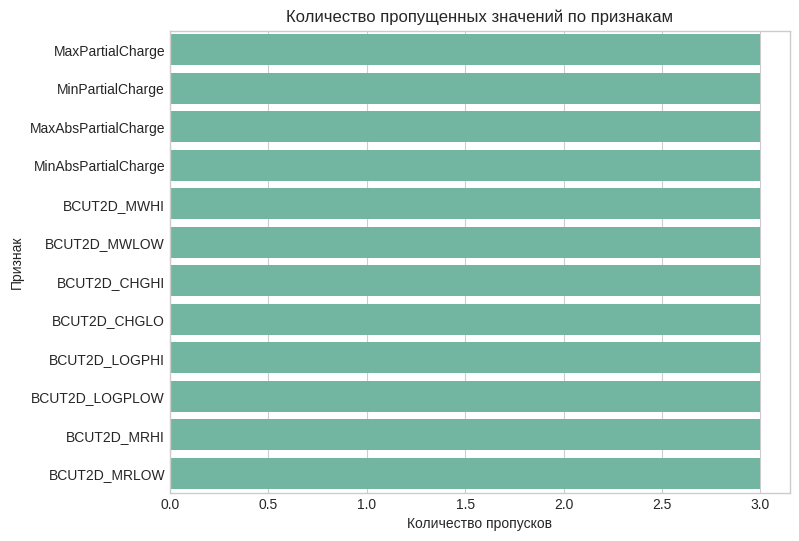

In [5]:
# === Анализ пропущенных значений ===
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Признаки с пропущенными значениями:")
display(missing)

# Визуализация пропусков
plt.figure(figsize=(8, 6))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Количество пропущенных значений по признакам")
plt.xlabel("Количество пропусков")
plt.ylabel("Признак")
plt.show()

In [6]:
# Пропущенных значений немного, удалим их для дальнейшего анализа

# Пропущенные значения
missing = df.isnull().sum().sort_values(ascending=False)
print("Пропуски:", missing[missing > 0])

# Удаление столбцов с одним уникальным значением
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
print(f"Удалено столбцов с одним уникальным значением: {len(cols_to_drop)}")

df = df.drop(columns=cols_to_drop)

Пропуски: MaxAbsPartialCharge    3
MinAbsPartialCharge    3
MaxPartialCharge       3
MinPartialCharge       3
BCUT2D_MWLOW           3
BCUT2D_MWHI            3
BCUT2D_MRLOW           3
BCUT2D_MRHI            3
BCUT2D_LOGPLOW         3
BCUT2D_LOGPHI          3
BCUT2D_CHGLO           3
BCUT2D_CHGHI           3
dtype: int64
Удалено столбцов с одним уникальным значением: 18


In [7]:
# === Удаление признаков с единственным уникальным значением ===
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
print(f"Удалено {len(cols_to_drop)} неинформативных признаков: {cols_to_drop}")
df.drop(columns=cols_to_drop, inplace=True)

Удалено 0 неинформативных признаков: []


In [8]:
# === Базовая статистика по числовым признакам ===
print("Описание числовых признаков:")
display(df.describe().T)

Описание числовых признаков:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1001.0,500.000000,289.108111,0.000000,250.000000,500.000000,750.000000,1000.000000
"IC50, mM",1001.0,222.805156,402.169734,0.003517,12.515396,46.585183,224.975928,4128.529377
"CC50, mM",1001.0,589.110728,642.867508,0.700808,99.999036,411.039342,894.089176,4538.976189
SI,1001.0,72.508823,684.482739,0.011489,1.433333,3.846154,16.566667,15620.600000
MaxAbsEStateIndex,1001.0,10.831637,3.307505,2.321942,9.252350,12.179236,13.167843,15.933463
...,...,...,...,...,...,...,...,...
fr_tetrazole,1001.0,0.000999,0.031607,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiazole,1001.0,0.051948,0.222033,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiophene,1001.0,0.069930,0.255157,0.000000,0.000000,0.000000,0.000000,1.000000
fr_unbrch_alkane,1001.0,0.204795,1.215326,0.000000,0.000000,0.000000,0.000000,20.000000


In [9]:
# === Анализ категориальных признаков (если есть) ===
cat_cols = df.select_dtypes(include="object").columns
print("Категориальные признаки:", list(cat_cols))

for col in cat_cols:
    print(f"\nАнализ признака: {col}")
    print(df[col].value_counts())

Категориальные признаки: []


In [10]:
# Заполним все пропуски медианой

cols_to_fill = [
    'MinAbsPartialCharge', 'MaxAbsPartialCharge', 'MinPartialCharge', 'MaxPartialCharge',
    'BCUT2D_LOGPHI', 'BCUT2D_MWHI', 'BCUT2D_MWLOW',
    'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI', 'BCUT2D_MRLOW'
]

# Безопасное и рекомендованное заполнение пропусков
for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].median())

In [11]:
for col in df.columns:
    dtype = df[col].dtype
    n_nan = df[col].isna().sum()

    if pd.api.types.is_numeric_dtype(df[col]):
        min_val = df[col].min(skipna=True)
        max_val = df[col].max(skipna=True)
        print(f"{col} | тип: {dtype} | NaN: {n_nan} | min: {min_val} | max: {max_val}")
    else:
        print(f"{col} | тип: {dtype} | NaN: {n_nan}")


Unnamed: 0 | тип: int64 | NaN: 0 | min: 0 | max: 1000
IC50, mM | тип: float64 | NaN: 0 | min: 0.003516693745208505 | max: 4128.529376550779
CC50, mM | тип: float64 | NaN: 0 | min: 0.700807912518016 | max: 4538.976188530915
SI | тип: float64 | NaN: 0 | min: 0.01148926945588554 | max: 15620.6
MaxAbsEStateIndex | тип: float64 | NaN: 0 | min: 2.321942215462859 | max: 15.93346261652809
MaxEStateIndex | тип: float64 | NaN: 0 | min: 2.321942215462859 | max: 15.93346261652809
MinAbsEStateIndex | тип: float64 | NaN: 0 | min: 3.921012849605887e-05 | max: 1.374614197530864
MinEStateIndex | тип: float64 | NaN: 0 | min: -6.992795611300078 | max: 1.374614197530864
qed | тип: float64 | NaN: 0 | min: 0.05956677724786782 | max: 0.9472648367815284
SPS | тип: float64 | NaN: 0 | min: 9.416666666666666 | max: 60.27272727272727
MolWt | тип: float64 | NaN: 0 | min: 110.156 | max: 904.7770000000005
HeavyAtomMolWt | тип: float64 | NaN: 0 | min: 100.076 | max: 856.393
ExactMolWt | тип: float64 | NaN: 0 | min: 1

In [12]:
df = df.drop(columns=['SPS'])
df = df.drop(columns=['Unnamed: 0'])

In [13]:
# Найдем коэфициент корреляции между IC50, mM и CC50, mM

correlation = df['IC50, mM'].corr(df['CC50, mM'])
print("Коэффициент корреляции Пирсона:", correlation)

Коэффициент корреляции Пирсона: 0.5213461579994008


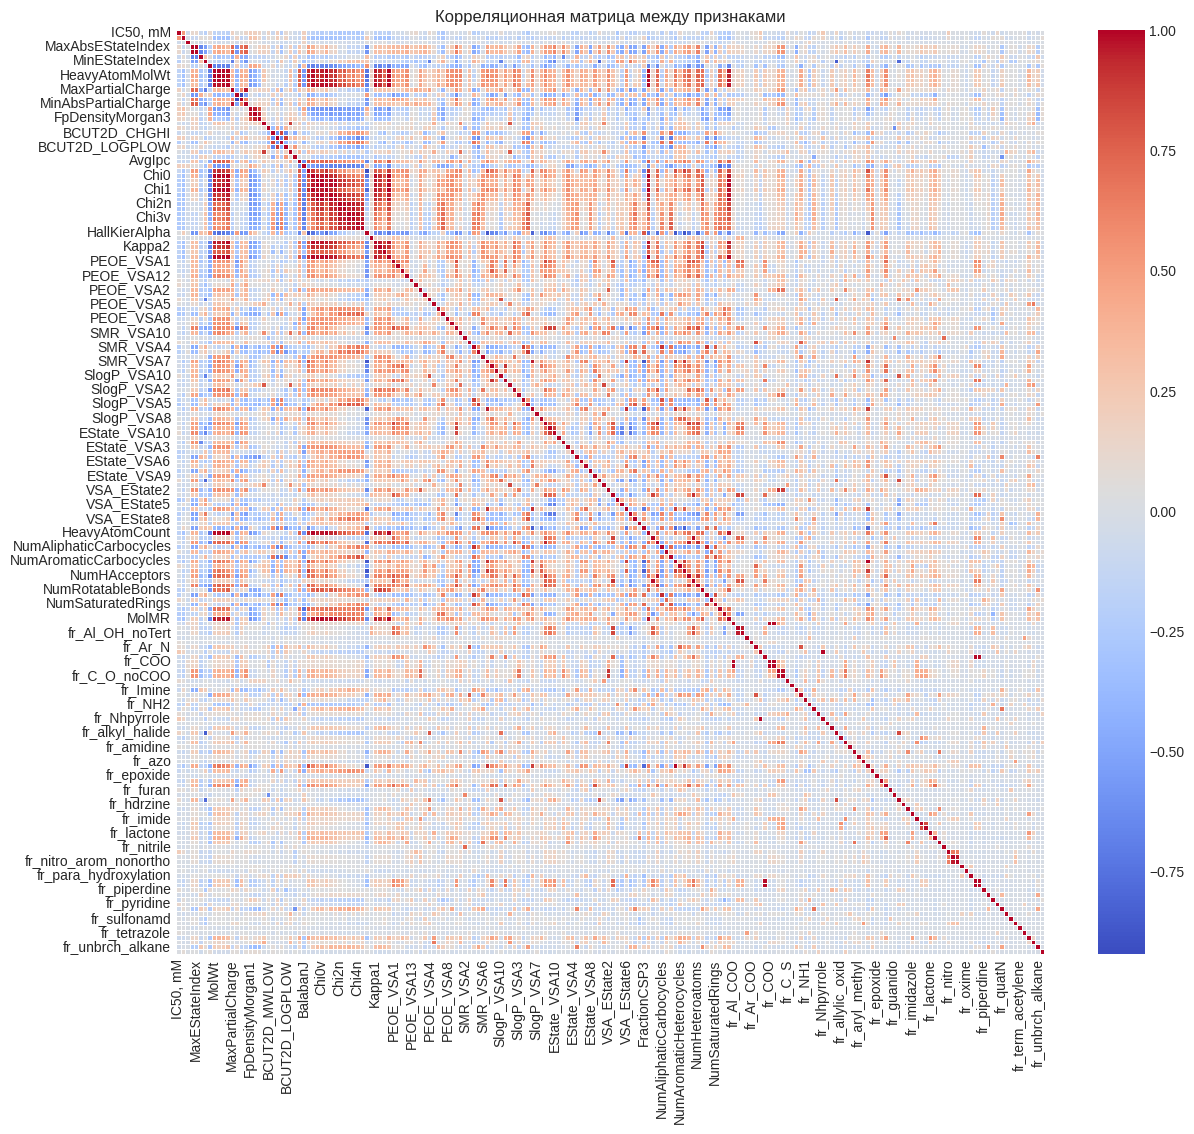

In [14]:
# === Корреляционный анализ ===
plt.figure(figsize=(14, 12))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица между признаками")
plt.show()

Для выявления взаимозависимостей между признаками был проведён корреляционный анализ. Визуализация представлена в виде тепловой карты, отражающей коэффициенты корреляции между всеми парами признаков.

**Комментарии к графику:**

* Цветовая шкала отражает значение коэффициента Пирсона: от -1 (сильная отрицательная корреляция, синий) до +1 (сильная положительная корреляция, красный).

* Диагональ (значение 1.0) — это автокорреляция признака с самим собой.

* Некоторые группы признаков (например, BCUT2D, SlogP_VSA, PEOE_VSA) демонстрируют высокую взаимную корреляцию — это видно по плотным красным квадратам вдоль диагонали.

* Наличие блоков высокой корреляции свидетельствует о возможной избыточности информации, которую в дальнейшем можно устранить путём отбора признаков.

In [15]:
# Функция для удаления признаков с высокой взаимной корреляцией
def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Удалено {len(to_drop)} признаков с корреляцией выше {threshold}")
    return df.drop(columns=to_drop), to_drop

# Применение к числовым признакам
df_reduced, dropped_features = remove_highly_correlated_features(df.select_dtypes(include='number'))

# Сохранения списка удалённых признаков
pd.Series(dropped_features).to_csv("dropped_correlated_features.csv", index=False)

Удалено 33 признаков с корреляцией выше 0.95


Удаление признаков с |r| > 0.95 помогает избежать мультиколлинеарности, которая может негативно сказаться на работе линейных моделей (например, LinearRegression, Ridge) и усложнить интерпретацию моделей.

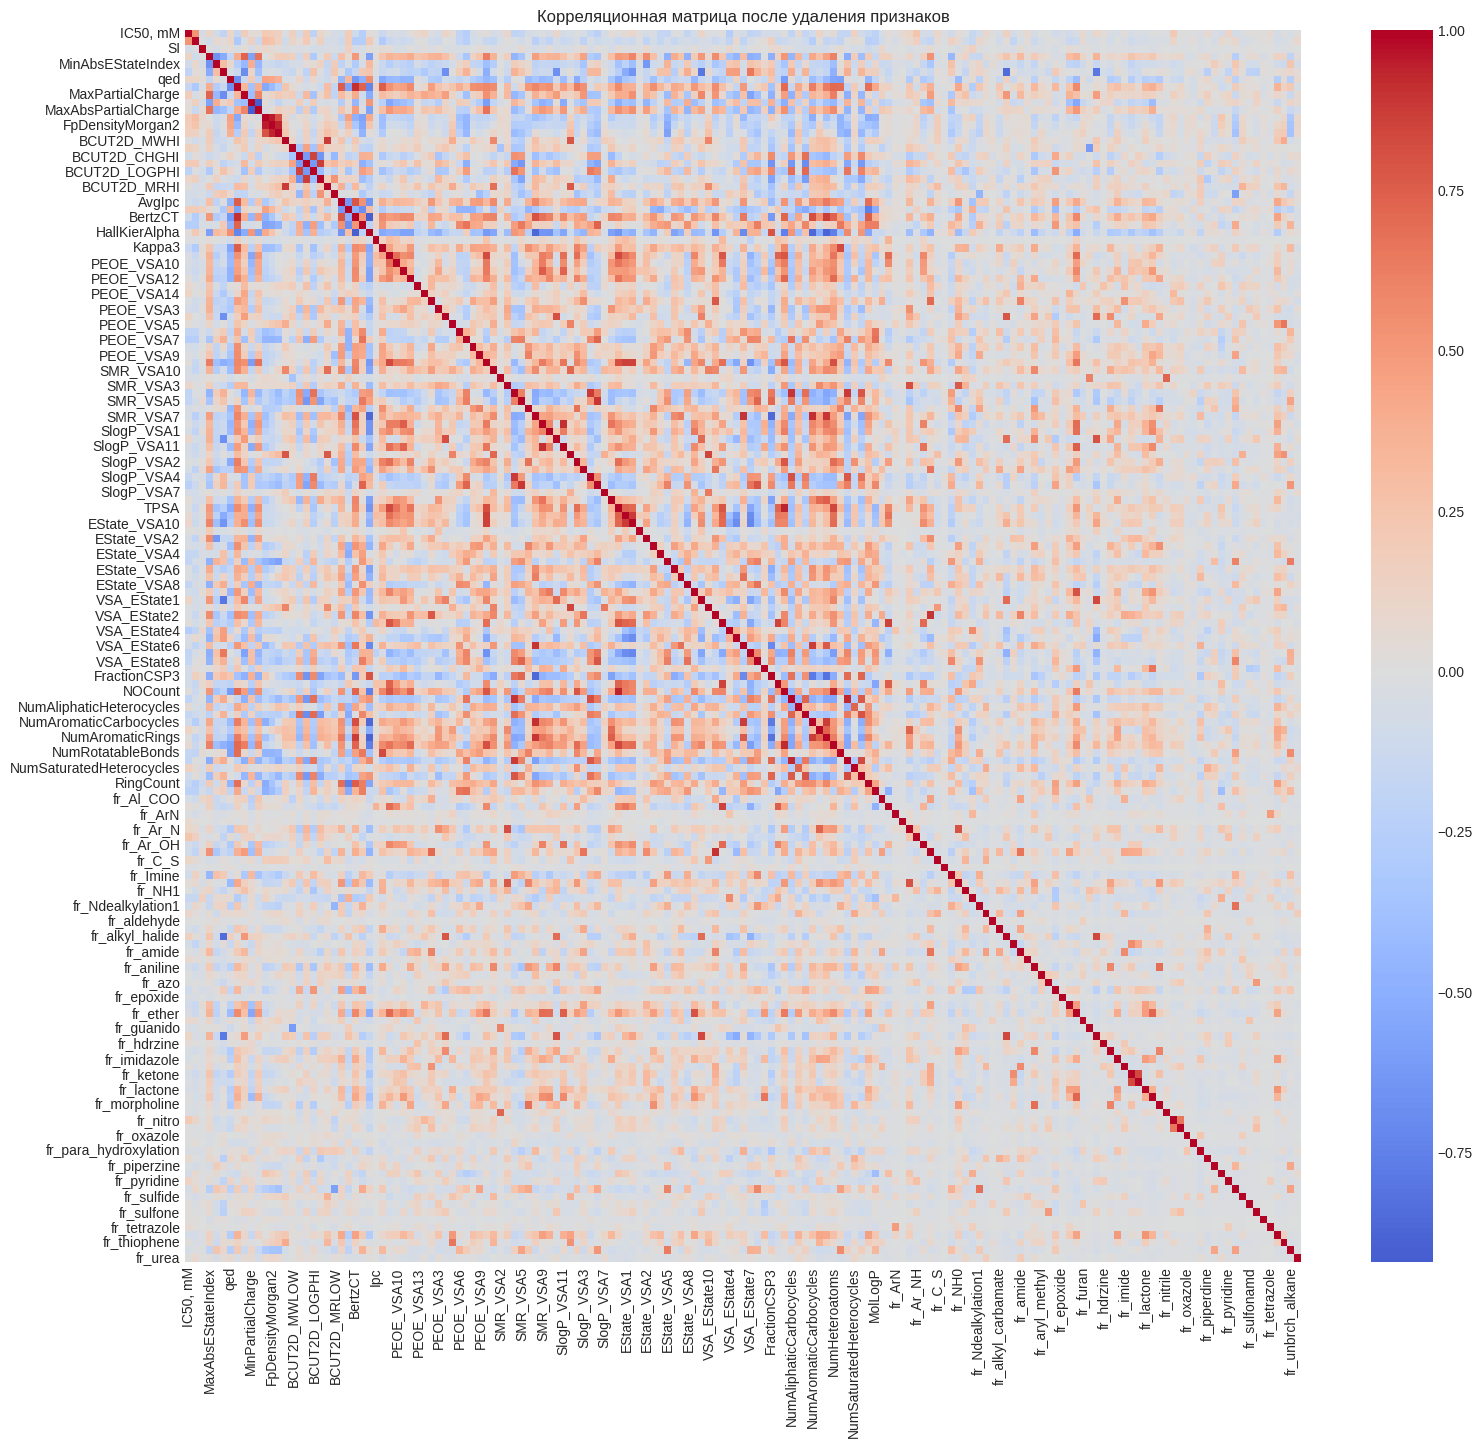

In [16]:
# После удаления:
plt.figure(figsize=(18, 16))
sns.heatmap(df_reduced.corr(), cmap='coolwarm', center=0)
plt.title("Корреляционная матрица после удаления признаков")
plt.show()

### Наблюдения:

##  Общее снижение насыщенности цветов

* 🔽 В сравнении с первой матрицей (до удаления), здесь заметно меньше  ярко-красных и ярко-синих квадратов. Это свидетельствует о том, что признаки с высокой корреляцией (|r| > 0.95) были успешно удалены.

* Остались слабые и умеренные корреляции
▫️ Многие признаки продолжают демонстрировать слабую или умеренную корреляцию (|r| от 0.1 до 0.6), что допустимо и может быть полезно для модели.

* Сохранилась автокорреляция на диагонали
* 🔴 Диагональ по-прежнему тёмно-красная — это автокорреляция, как и ожидается (r = 1.0).

* Некоторые блоки структуры всё ещё видны
* Например, у PEOE_VSA и SlogP_VSA можно заметить некоторую остаточную структуру, но без сильных взаимозависимостей.

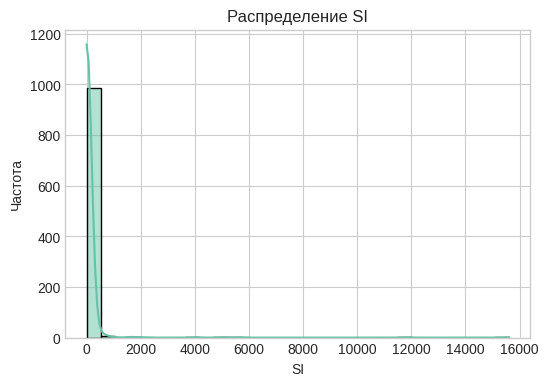

In [17]:
# === Распределения ключевых переменных ===
for col in ["IC50", "CC50", "SI"]:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Распределение {col}")
        plt.xlabel(col)
        plt.ylabel("Частота")
        plt.show()

Переменная SI имеет сильно неравномерное распределение с длинным правым хвостом и наличием выбросов.

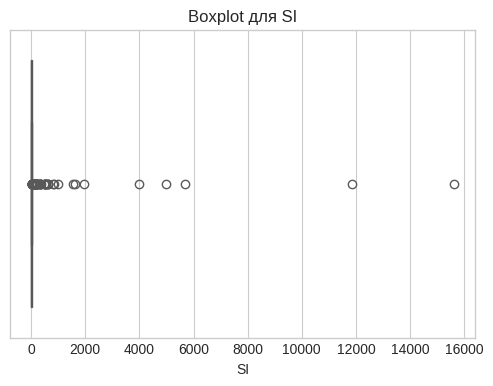

In [18]:
# === Анализ выбросов через boxplot ===
for col in ["IC50", "CC50", "SI"]:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot для {col}")
        plt.show()

**Явно выраженные выбросы в данных**
* На графике отчётливо видны отдельные точки за пределами "усов" — это значения, выходящие за границы стандартного диапазона (1.5 × IQR от 1-го и 3-го квартиля). Они считаются выбросами по методу Тьюки.
* Сильная положительная асимметрия (right-skew)
* Основной box (межквартильный интервал) сосредоточен вблизи 0–500, в то время как усы и выбросы тянутся далеко вправо — до значений 15 000+. Это подтверждает результат предыдущего графика (распределение SI).
* Данные несимметричны и содержат экстремумы
* Верхний ус сильно вытянут, нижний — короткий или отсутствует. Это характерно для биологических и химических индексов, где возможны "редкие, но высокоэффективные" молекулы.

In [19]:
# Определим важность признаков чтобы понимать с какими в 1 очередь нужно работать

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Предполагаем, что DataFrame 'df' уже загружен

def get_top_features(df, target_column, n_top=30, exclude_features=[]):
    # Ищем признаки, которые нужно исключить (в т.ч. содержащие 'IC50' или 'CC50')
    excluded_substrings = ['IC50', 'CC50']
    exclude_features_set = set(exclude_features)

    for col in df.columns:
        if any(substr in col for substr in excluded_substrings):
            exclude_features_set.add(col)

    # Оставляем только допустимые признаки
    X_raw = df.drop(columns=[target_column] + list(exclude_features_set), errors='ignore')
    y = df[target_column]

    # Обработка пропусков
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X_raw)

    # Обучение модели
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)

    # Важность признаков
    importances = rf.feature_importances_
    feat_importance = pd.Series(importances, index=X_raw.columns).sort_values(ascending=False)

    return feat_importance.head(n_top)

# Получаем важные признаки для обоих таргетов
top_ic50 = get_top_features(df, 'IC50, mM', n_top=30, exclude_features=['SI'])
top_cc50 = get_top_features(df, 'CC50, mM', n_top=30, exclude_features=['SI'])

# Находим первые 5 общих признаков
common_features = []
i = 1
while len(common_features) < 5 and i <= 30:
    ic50_set = set(top_ic50.head(i).index)
    cc50_set = set(top_cc50.head(i).index)
    common = ic50_set.intersection(cc50_set)
    common_features = list(common)
    i += 1

common_features = common_features[:5]

print("Общие топ-5 важных признаков (без 'SI' и признаков с 'IC50'/'CC50' в имени):")
for idx, f in enumerate(common_features, 1):
    print(f"{idx}. {f}")

# Создаём полиномиальные признаки для этих 5 признаков
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_poly_raw = df[common_features]
imputer = SimpleImputer(strategy='mean')
X_poly = imputer.fit_transform(X_poly_raw)
X_poly_transformed = poly.fit_transform(X_poly)

# Заменяем пробелы на подчёркивания в названиях новых признаков
poly_feature_names = [name.replace(" ", "_") for name in poly.get_feature_names_out(common_features)]

# Создаём DataFrame с новыми именами признаков
poly_df = pd.DataFrame(X_poly_transformed, columns=poly_feature_names, index=df.index)

# Добавляем в оригинальный DataFrame
df = pd.concat([df, poly_df], axis=1)

# Выводим сообщение о добавленных признаках
print("\nДобавлены полиномиальные признаки:")
for f in poly_feature_names:
    if f not in common_features:
        print(f"- {f}")

Общие топ-5 важных признаков (без 'SI' и признаков с 'IC50'/'CC50' в имени):
1. VSA_EState4
2. Chi1n
3. BCUT2D_MWLOW
4. Kappa2
5. BCUT2D_MRLOW

Добавлены полиномиальные признаки:
- VSA_EState4^2
- VSA_EState4_Chi1n
- VSA_EState4_BCUT2D_MWLOW
- VSA_EState4_Kappa2
- VSA_EState4_BCUT2D_MRLOW
- Chi1n^2
- Chi1n_BCUT2D_MWLOW
- Chi1n_Kappa2
- Chi1n_BCUT2D_MRLOW
- BCUT2D_MWLOW^2
- BCUT2D_MWLOW_Kappa2
- BCUT2D_MWLOW_BCUT2D_MRLOW
- Kappa2^2
- Kappa2_BCUT2D_MRLOW
- BCUT2D_MRLOW^2


In [20]:
print(df.columns.tolist())

['IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',

CC50, mM               0.543256
SI                     0.392219
BCUT2D_CHGLO           0.007429
Chi1n_Kappa2           0.003318
BCUT2D_MWLOW           0.002996
SMR_VSA3               0.002976
Kappa2^2               0.002867
Kappa2                 0.002857
EState_VSA4            0.002690
Kappa1                 0.001983
Kappa3                 0.001681
MolMR                  0.001620
Chi1n_BCUT2D_MWLOW     0.001499
BCUT2D_MWLOW^2         0.001259
BertzCT                0.001216
ExactMolWt             0.001089
HeavyAtomMolWt         0.001070
BCUT2D_MWLOW           0.001032
BCUT2D_LOGPHI          0.001027
BCUT2D_MWHI            0.001024
Kappa2                 0.001003
LabuteASA              0.000947
MolWt                  0.000937
MinEStateIndex         0.000817
Chi0n                  0.000768
MinAbsEStateIndex      0.000683
MaxAbsPartialCharge    0.000610
EState_VSA8            0.000602
VSA_EState4            0.000535
VSA_EState3            0.000526
dtype: float64


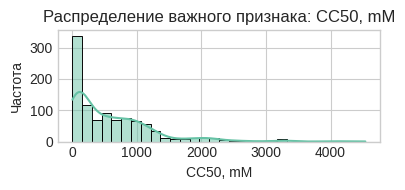

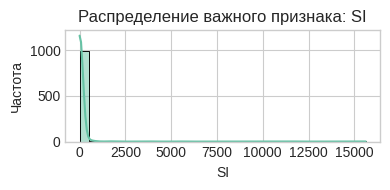

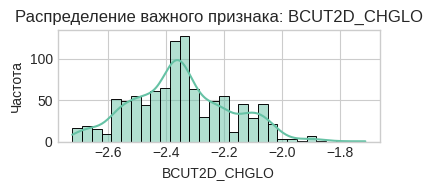

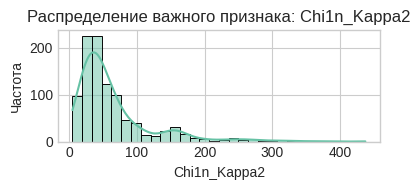

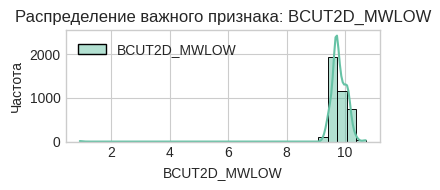

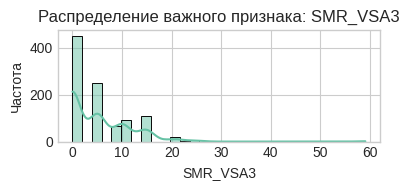

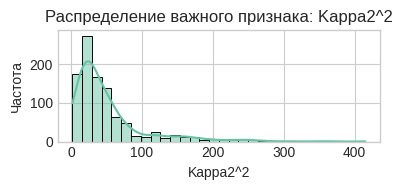

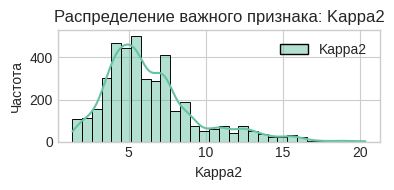

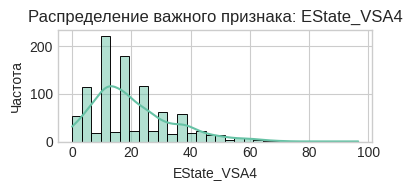

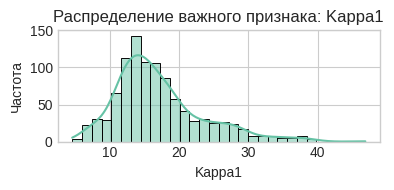

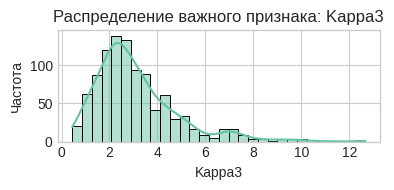

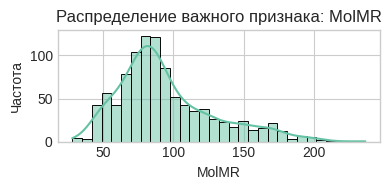

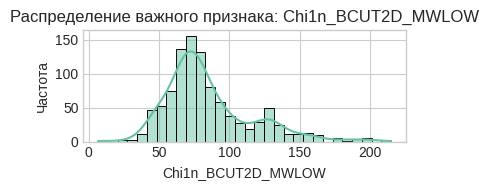

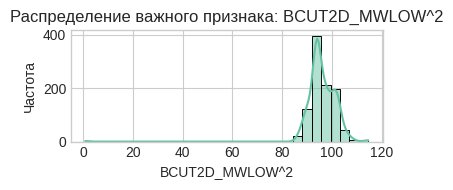

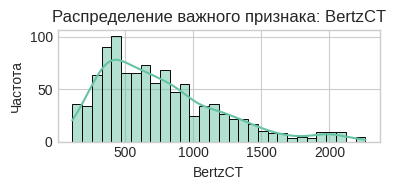

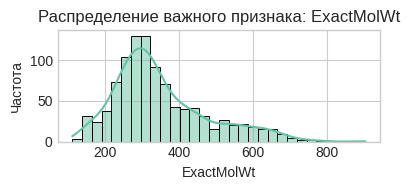

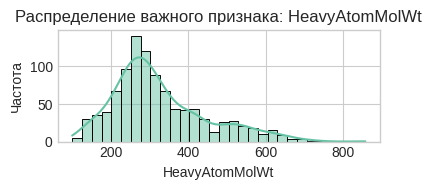

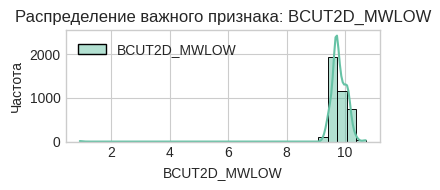

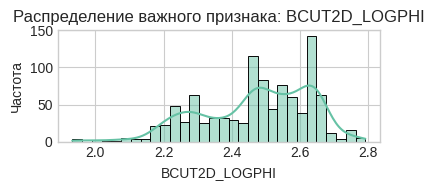

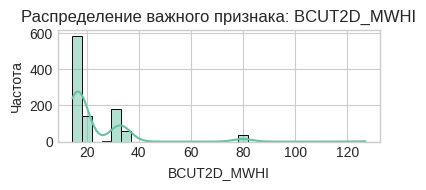

In [21]:
# Отделим целевую переменную и признаки
X_raw = df.drop(columns=['IC50, mM'])  # признаки
y = df['IC50, mM']  # целевая переменная

# Обработка пропусков (если есть)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)

# Обучаем модель
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Получаем важность признаков
importances = rf.feature_importances_

# Сопоставим с названиями признаков
feat_importance = pd.Series(importances, index=X_raw.columns)
feat_importance = feat_importance.sort_values(ascending=False)

# Покажем топ-20 признаков
print(feat_importance.head(30))

# Строим гистограммы для топ-10 важных признаков
top_features = feat_importance.head(20).index

for column in top_features:
    plt.figure(figsize=(4, 2))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение важного признака: {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

Таким образом, мы применили RandomForestRegressor для оценки важности признаков.

Это известная практика в химии и биоинформатике, особенно если нет экспертного отбора признаков.


# **Data Engineering**

In [24]:
import numpy as np

# Если твой датафрейм называется df
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Подсчёт количества отрицательных значений по столбцам
neg_counts = (df[numeric_cols] < 0).sum().sort_values(ascending=False)

# Вывод признаков с хотя бы одним отрицательным значением
print("Признаки с отрицательными значениями:")
print(neg_counts[neg_counts > 0])

Признаки с отрицательными значениями:
MinPartialCharge             1001
BCUT2D_CHGLO                 1001
BCUT2D_LOGPLOW               1001
HallKierAlpha                 992
MinEStateIndex                738
BCUT2D_MRLOW                  643
BCUT2D_MRLOW                  643
Chi1n_BCUT2D_MRLOW            643
BCUT2D_MRLOW                  643
Kappa2_BCUT2D_MRLOW           643
BCUT2D_MWLOW_BCUT2D_MRLOW     643
BCUT2D_MRLOW                  643
VSA_EState4_BCUT2D_MRLOW      496
VSA_EState5                   362
VSA_EState4                   205
VSA_EState4                   205
VSA_EState4_BCUT2D_MWLOW      205
VSA_EState4                   205
VSA_EState4_Chi1n             205
VSA_EState4_Kappa2            205
VSA_EState4                   205
VSA_EState7                   168
MolLogP                        53
VSA_EState8                    36
VSA_EState6                    34
VSA_EState9                    31
VSA_EState3                    13
MaxPartialCharge                7
VSA_EState

наличие стольких признаков с отрицательными значениями в задаче предсказания биологических свойств молекул требует очень осторожного подхода, и просто удалять строки — не всегда разумно.

Некоторые признаки в химии и хемоинформатике вполне допустимы с отрицательными значениями, например:

Признак	Что это может значить
* **MolLogP** Гидрофильность / гидрофобность молекулы (может быть < 0)
* **MinPartialCharge**	Частичный заряд на атоме (может быть < 0)
* **HallKierAlpha**	Структурный дескриптор — тоже может быть < 0
* **EState и VSA_EState** Индексы электронного состояния — часто бывают отрицательными

Почему нельзя удалять все строки с отрицательными значениями:
+ Это может исказить распределения признаков;
+ Удаляется до 1000+ строк, а это уже небезопасная потеря данных;
+ Некоторые признаки в химии по определению имеют отрицательные значения, это не ошибка, а свойство данных.




In [27]:
print(df.columns.tolist())

['IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',

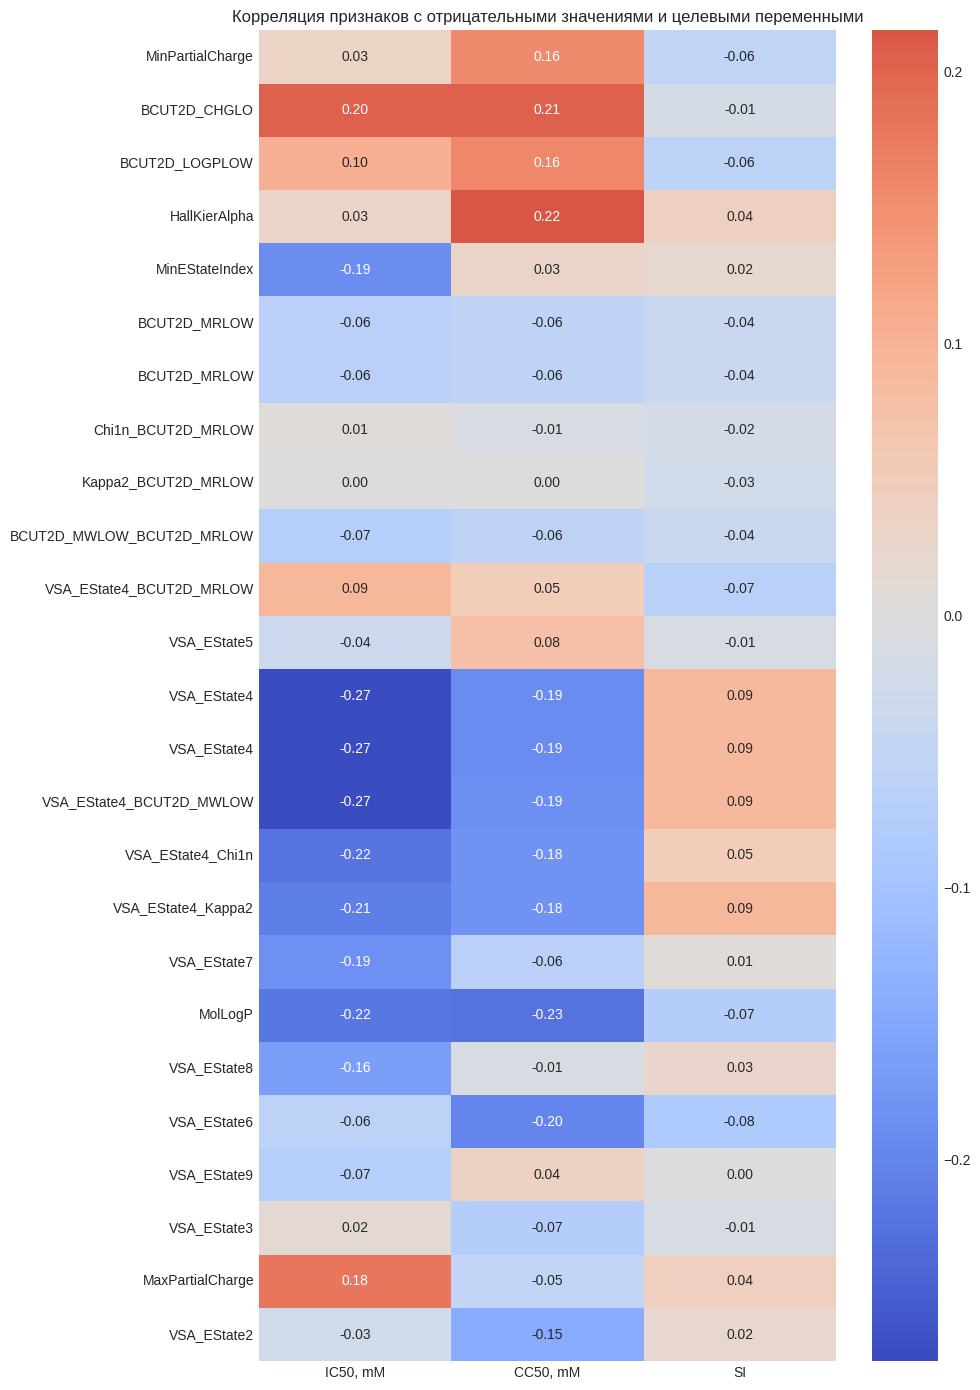

In [28]:
# Список признаков с отрицательными значениями (твоя таблица)
neg_features = [
    'MinPartialCharge', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'HallKierAlpha',
    'MinEStateIndex', 'BCUT2D_MRLOW', 'Chi1n_BCUT2D_MRLOW', 'Kappa2_BCUT2D_MRLOW',
    'BCUT2D_MWLOW_BCUT2D_MRLOW', 'VSA_EState4_BCUT2D_MRLOW', 'VSA_EState5',
    'VSA_EState4', 'VSA_EState4_BCUT2D_MWLOW', 'VSA_EState4_Chi1n',
    'VSA_EState4_Kappa2', 'VSA_EState7', 'MolLogP', 'VSA_EState8', 'VSA_EState6',
    'VSA_EState9', 'VSA_EState3', 'MaxPartialCharge', 'VSA_EState2'
]

# Таргеты
targets = ['IC50, mM', 'CC50, mM', 'SI']

# Все нужные колонки
selected_cols = list(set(neg_features + targets))

# Оставим только нужные признаки
df_corr = df[selected_cols].copy()

# Корреляционная матрица
corr_matrix = df_corr.corr()

# Отобразим только корреляцию с таргетами
corr_with_targets = corr_matrix[targets].loc[neg_features]

# Визуализация
plt.figure(figsize=(10, 14))
sns.heatmap(corr_with_targets, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляция признаков с отрицательными значениями и целевыми переменными")
plt.tight_layout()
plt.show()


In [29]:
selected_features = [
    'VSA_EState4', 'VSA_EState4_Chi1n', 'VSA_EState4_Kappa2',
    'MolLogP', 'VSA_EState6', 'VSA_EState4_BCUT2D_MWLOW', 'VSA_EState7'
]

In [30]:
excluded_features = [
    'Chi1n_BCUT2D_MRLOW', 'Kappa2_BCUT2D_MRLOW',
    'VSA_EState5', 'VSA_EState3', 'MaxPartialCharge', 'VSA_EState2'
]

In [31]:
# Удалим признаки с низкой корреляцией
df.drop(columns=excluded_features, inplace=True)

### 📌 **Выводы по Feature Engineering**
* В рамках инженерии признаков был проведён целенаправленный анализ дескрипторов, содержащих отрицательные значения. Поскольку многие из них представляют собой валидные химические или электронные параметры (например, частичные заряды, логарифмы распределения, индексы EState), они не были удалены автоматически. Вместо этого была рассчитана корреляция этих признаков с целевыми переменными (IC50, mM, CC50, mM, SI), чтобы выявить их информативность.

* ## **🔹 Сохраняем в модели:**
* Признаки **VSA_EState4, MolLogP, VSA_EState6, VSA_EState4_Chi1n, VSA_EState4_Kappa2, VSA_EState4_BCUT2D_MWLOW, VSA_EState7** показали наибольшую корреляцию с целевыми переменными и были оставлены для последующего моделирования.

* ## **🔸 Исключаем:**
* Признаки с почти нулевой корреляцией (**Chi1n_BCUT2D_MRLOW, Kappa2_BCUT2D_MRLOW, VSA_EState5, VSA_EState3, VSA_EState2, MaxPartialCharge**) не вносят вклада в предсказательную способность модели и были удалены как потенциально шумовые.

* Таким образом, отбор признаков был проведён с учётом биохимической интерпретируемости и корреляционного анализа, что позволило сохранить только потенциально значимые дескрипторы для построения моделей регрессии и классификации.

